In [1]:
import numpy as np
import os
import scipy.io.wavfile as wav
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import random
%matplotlib inline

In [2]:
class extract_features(object):
    def __init__(self,window,frame_length,sampling_rate):
        self.window = window
        self.frame_length = frame_length
        self.sampling_rate = sampling_rate
        self.split_frames()
        self.ZCR()
        self.RMS()
        self.fft_normalization()
        self.spectral_flux()
        self.spectral_rolloff()
        self.spectral_centroid()
        self.bandwidth()
        self.return_()
    def split_frames(self):
        self.frames = []
        samples_per_frame = int((self.frame_length*(10**-3))*self.sampling_rate)
        index = 0
        while index < len(self.window):
            self.frames.append(self.window[index:index+samples_per_frame])
            index += samples_per_frame
        print(len(self.frames))
    def ZCR(self):
        prev_value = 1
        count = 0
        for each in self.window:
            if (prev_value*each) < 0:
                count += 1
            prev_value = each
        self.ZCR = count/(len(self.window)-1)
        print("ZCR:",count/(len(sig)-1))
    def RMS(self):
        RMS_entire_frame = np.sqrt(np.mean(self.window**2))
        print("RMS:",RMS_entire_frame)
        RMS_count = 0
        for each_frame in self.frames:
            RMS_current_frame = np.sqrt(np.mean(each_frame**2))
            if RMS_current_frame < 0.5*(RMS_entire_frame):
                RMS_count += 1
        print("Low Energy frame rate:",RMS_count)
        self.RMS_count = RMS_count
    def fft_normalization(self):
        self.frames_fft_normalised = []
        self.frames_freq_bins = []
        self.frames_phase_angle_bins = []
        for each_frame in self.frames:
            fft_ = np.fft.fft(each_frame)
            fft_frame = np.absolute(fft_)
            phase_angle = np.angle(fft_,deg = True)[1:]
            frames_freq = np.fft.fftfreq(len(each_frame),d = (1/self.sampling_rate))[1:]
            fft_frame_normalised = fft_frame[1:]/(np.sum(abs(fft_frame[1:])))
            self.frames_fft_normalised.append(fft_frame_normalised[frames_freq>0])
            self.frames_freq_bins.append(frames_freq[frames_freq>0])
            self.frames_phase_angle_bins.append(phase_angle[frames_freq>0])

        #plt.scatter(self.frames_freq_bins[0],self.frames_phase_angle_bins[0])
    def spectral_flux(self):
        self.spectral_flux = []
        for frame_index in range(len(self.frames)):
            test = copy.deepcopy(self.frames_fft_normalised[frame_index])
            test = np.insert(test,len(test),1)
            test_1 = copy.deepcopy(self.frames_fft_normalised[frame_index])
            test_1 = np.insert(test_1,0,1)
            self.spectral_flux.append(np.sum((test - test_1)[1:-1]**2))
        #plt.scatter(np.arange(len(self.frames)),self.spectral_flux)
    def spectral_rolloff(self):
        self.spectral_rolloff = []
        percentage = 0.93
        for frame_index in range(len(self.frames)):
            spectral_cum_sum = np.cumsum(self.frames_fft_normalised[frame_index])
            roll_of_percentage = percentage*spectral_cum_sum[-1]
            lower_spectral_indices = np.argwhere(spectral_cum_sum<roll_of_percentage)
            spectral_roll_off_f = self.frames_freq_bins[frame_index][lower_spectral_indices[-1][0]]
            self.spectral_rolloff.append(spectral_roll_off_f)
        #plt.scatter(np.arange(len(self.frames)),self.spectral_rolloff)
    def spectral_centroid(self):
        self.spectral_centroid = []
        for frame_index in range(len(self.frames)):
            num = np.sum(self.frames_freq_bins[frame_index]*(self.frames_fft_normalised[frame_index]**2))
            den = np.sum(self.frames_fft_normalised[frame_index]**2)
            self.spectral_centroid.append(num/den)
        #plt.scatter(np.arange(len(self.frames)),self.spectral_centroid)
    def bandwidth(self):
        self.bandwidth_ = []
        for frame_index in range(len(self.frames)):
            num = np.sum(((self.frames_freq_bins[frame_index] - self.spectral_centroid[frame_index])**2)*\
                         (self.frames_fft_normalised[frame_index]**2))
            den = np.sum(self.frames_fft_normalised[frame_index]**2)
            self.bandwidth_.append(num/den)
        #plt.scatter(np.arange(len(self.frames)),self.bandwidth_)
    def return_(self):
        return [self.ZCR,self.RMS_count,self.spectral_flux,\
                self.spectral_rolloff,self.spectral_centroid,self.bandwidth_]

In [3]:
ROOT_FOLDER = "/Users/siva/Documents/speaker_recognition/datasets/musan/testing/"
FRAME_LENGTH = 25
os.chdir(ROOT_FOLDER)
all_audio = os.listdir()
sample_size = 960000
dataset_dict = {"ZCR":[],"RMS":[],"spectral_flux":[],\
               "spectral_centroid":[],"spectral_rolloff":[],\
               "bandwidth":[],"audio":[]}
for audio in all_audio:
    if "noise" in audio or "music" in audio or "speech" in audio:
        print("****************************")
        print("reading:",audio)
        sampling_rate,sig = wav.read(ROOT_FOLDER+audio)
        print("sampling rate:",sampling_rate,"signal length",len(sig))
        index_1 = int((len(sig)//2)-(sample_size//2))
        index_2 = int((len(sig)//2)+(sample_size//2))
        sample = sig[index_1:index_2]
        print(len(sample))
        ZCR,RMS,sf,sr,sc,bd = extract_features(sample,FRAME_LENGTH,sampling_rate).return_()
        dataset_dict["ZCR"].append(ZCR)
        dataset_dict["RMS"].append(RMS)
        dataset_dict["spectral_flux"].append(sf)
        dataset_dict["spectral_centroid"].append(sc)
        dataset_dict["spectral_rolloff"].append(sr)
        dataset_dict["bandwidth"].append(bd)
        if audio.split("-")[0] == "noise":
            dataset_dict["audio"].append("r") #RED -> NOISE
        elif audio.split("-")[0] == "music":
            dataset_dict["audio"].append("g") #GREEN -> MUSIC
        elif audio.split("-")[0] == "speech":
            dataset_dict["audio"].append("b") #BLUE -> SPEECH

****************************
reading: music-fma-0003.wav
sampling rate: 16000 signal length 5196487
960000
2400
ZCR: 0.09226638924842673
RMS: nan
Low Energy frame rate: 0
****************************
reading: noise-sound-bible-0048.wav
sampling rate: 16000 signal length 1002266
960000
2400
ZCR: 0.4758252557956229
RMS: 25.4414461517
Low Energy frame rate: 127
****************************
reading: noise-free-sound-0042.wav
sampling rate: 16000 signal length 5112895
960000
2400
ZCR: 0.09370524794763983
RMS: 26.0587778317
Low Energy frame rate: 122
****************************
reading: speech-librivox-0002.wav
sampling rate: 16000 signal length 4059638
960000
2400
ZCR: 0.09947588910042943
RMS: 44.7830427473
Low Energy frame rate: 296
****************************
reading: music-fma-wa-0011.wav
sampling rate: 16000 signal length 2036297
960000
2400
ZCR: 0.22940721781116302
RMS: 15.7565781898
Low Energy frame rate: 106
****************************
reading: speech-librivox-0006.wav
sampling ra

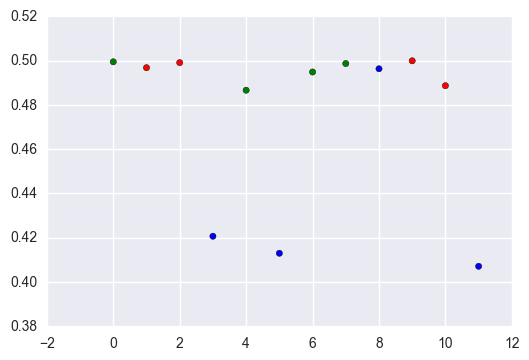

In [4]:
plt.scatter(np.arange(len(dataset_dict["ZCR"])),dataset_dict["ZCR"],c = dataset_dict["audio"])

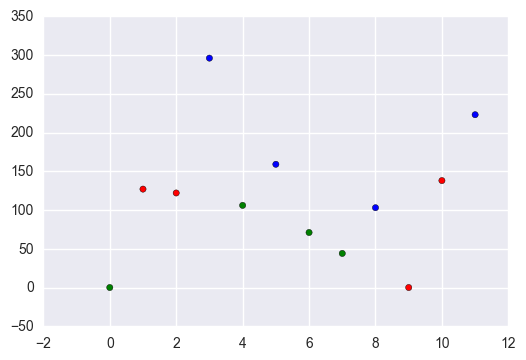

In [5]:
plt.scatter(np.arange(len(dataset_dict["RMS"])),dataset_dict["RMS"],c = dataset_dict["audio"])

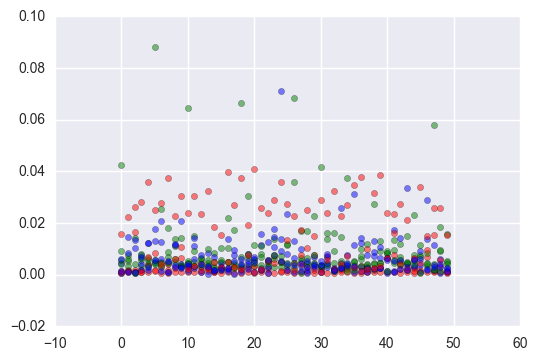

In [6]:
for i in range(len(dataset_dict["spectral_flux"])):
    ri = random.sample(dataset_dict["spectral_flux"][i],k = 50)
    plt.scatter(np.arange(len(ri)),ri,c = dataset_dict["audio"][i],alpha = 0.5)

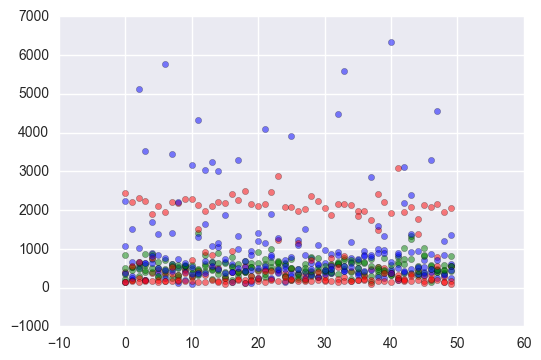

In [11]:
for i in range(len(dataset_dict["spectral_centroid"])):
    ri = random.sample(dataset_dict["spectral_centroid"][i],k = 50)
    plt.scatter(np.arange(len(ri)),ri,c = dataset_dict["audio"][i],alpha = 0.5)

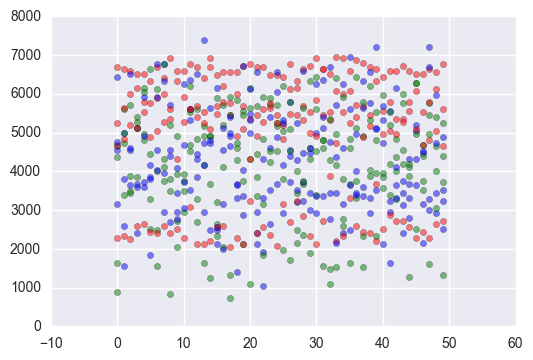

In [12]:
for i in range(len(dataset_dict["spectral_rolloff"])):
    ri = random.sample(dataset_dict["spectral_rolloff"][i],k = 50)
    plt.scatter(np.arange(len(ri)),ri,c = dataset_dict["audio"][i],alpha = 0.5)

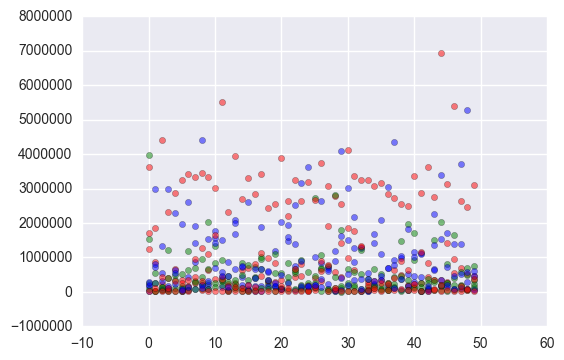

In [13]:
for i in range(len(dataset_dict["bandwidth"])):
    ri = random.sample(dataset_dict["bandwidth"][i],k = 50)
    plt.scatter(np.arange(len(ri)),ri,c = dataset_dict["audio"][i],alpha = 0.5)